## **Name:** Lauren Medica

## **Computing ID:BFG4MJ

# Lab 2: Machine Learning Evaluation (100 Points)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# **Candidate Messy Datasets for Part 1:**
* Tidy Tuesday
   * https://github.com/rfordatascience/tidytuesday/tree/main/data
* Hugging Face
   * https://huggingface.co/datasets/nateraw/airplane-crashes-and-fatalities
* Kaggle
   * https://www.kaggle.com/datasets/borapajo/food-choices?select=food_coded.csv
   * https://www.kaggle.com/datasets/mahnazarjmand/breast-cancer-data?resource=download




## Part 1: KNN and Regression Model Evaluation (30 Points)

## **Question 1 (15 points):**
## Read in or load a dataset as a Pandas DataFrame with at least 5 features (columns) and a categorical target column.

## Create a new DataFrame called clean_df that incorporates these preprocessing steps in **separate cells**. Complete each step regardless of if they have no effect on your data:
0. Call dtypes on the DataFrame
1. Drop rows that are completely empty
2. Replace missing values ("null", 0, empty strings) with proper NaNs
3. Impute NaNs using any method that sklearn supports
4. Drop any features that seem highly uncorrelated to your target so long as you still retain at least 5 features
5. Normalize and/or scale numerical columns using any method that sklearn supports
6. Encode any categorical columns using appropriate method (ordinal, one hot encoding)
7. Any additional preprocessing required for your data (ie: removing dollar signs from string columns and casting it is a float)

In [4]:
!pip install datasets
from datasets import load_dataset
ds = load_dataset("nateraw/airplane-crashes-and-fatalities")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == 

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.94k [00:00<?, ?B/s]

(…)ne_Crashes_and_Fatalities_Since_1908.csv:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5268 [00:00<?, ? examples/s]

In [5]:
ds = load_dataset("nateraw/airplane-crashes-and-fatalities")
df = ds['train'].to_pandas()
print(df.dtypes)
clean_df = df.dropna(how='all')
clean_df = clean_df.replace({"null": np.nan, 0: np.nan, "": np.nan})
for col in clean_df.columns:
    if clean_df[col].dtype == 'object':  # Categorical column
        clean_df[col] = clean_df[col].fillna(clean_df[col].mode()[0])
    else:  # Numerical column
        clean_df[col] = clean_df[col].fillna(clean_df[col].mean())
clean_df = clean_df.drop(columns=['Date'])
clean_df = clean_df.drop(columns=['Time'])
numerical_features = clean_df.select_dtypes(include=np.number).columns
for col in numerical_features:
    min_val = clean_df[col].min()
    max_val = clean_df[col].max()
    clean_df[col] = (clean_df[col] - min_val) / (max_val - min_val)
categorical_features = clean_df.select_dtypes(include='object').columns
clean_df = pd.get_dummies(clean_df, columns=categorical_features, drop_first=True)

index             int64
Date             object
Time             object
Location         object
Operator         object
Flight #         object
Route            object
Type             object
Registration     object
cn/In            object
Aboard          float64
Fatalities      float64
Ground          float64
Summary          object
dtype: object


## **Question 2 (5 points):**
## Implement a train test split with a ratio of your choosing for the training and test datasets.

## Instantiate and fit a vanilla (default) logistic regression classifier and a K-Nearest Neighbor model on your clean datasets and target.



In [8]:
target_variable = 'Fatalities'
clean_df['Fatalities_Category'] = pd.cut(clean_df['Fatalities'], bins=[-1, 0, 10, 50, float('inf')],
                                        labels=['None', 'Low', 'Medium', 'High'])
X = clean_df.drop(columns=[target_variable, 'Fatalities_Category'])
y = clean_df['Fatalities_Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)
knn_model = KNeighborsClassifier()

## **Question 3 (5 points):**
## Next, familiarize yourself with the sklearn documentation for each model and their parameters. Pick 2 parameters that you want to adjust from their default values in each of the models.
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model
* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

## Instantiate and fit a logistic regression classifier and a K-Nearest Neighbor model with these **updated** parameters on your clean datasets and target.

In [7]:
logreg_model_updated = LogisticRegression(
    solver='liblinear',
    C=0.8,
    max_iter = 10000
)
logreg_model_updated.fit(X_train, y_train)
knn_model_updated = KNeighborsClassifier(
    n_neighbors=7,
    weights='distance'
)
knn_model_updated.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7, weights='distance')

## **Question 4 (5 points):**
## Compile the following metrics for all 4 of your models into one DataFrame called metrics_df. Each model should have each metric reported.


1. Accuracy Score
2. Precision
3. Sensitivity
4. Specificity
5. F1 Score


## The first column of metrics_df has been created for you.

In [9]:
model_strings = ["Default Logistic Regression", "Default KNN", "Updated Logistic Regression", "Updated KNN"]
metrics_df = pd.DataFrame(index=model_strings)
metrics_df["Accuracy Score"] = [0, 0, 0, 0]
metrics_df

,Accuracy Score
Default Logistic Regression,0
Default KNN,0
Updated Logistic Regression,0
Updated KNN,0


In [57]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np

X = clean_df.drop(columns=["Fatalities", "Fatalities_Category"])
y = clean_df["Fatalities_Category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

logreg_model_updated = LogisticRegression(solver='liblinear', C=0.8, max_iter=10000)
logreg_model_updated.fit(X_train, y_train)

knn_model_updated = KNeighborsClassifier(n_neighbors=7, weights='distance')
knn_model_updated.fit(X_train, y_train)

y_pred1 = logreg_model.predict(X_test)
y_pred2 = knn_model.predict(X_test)
y_pred3 = logreg_model_updated.predict(X_test)
y_pred4 = knn_model_updated.predict(X_test)

def get_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm.sum() - (cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm)).sum()
    fp = cm.sum() - np.diag(cm).sum() - tn
    return tn / (tn + fp) if (tn + fp) > 0 else 0

model_names = ["Default Logistic Regression", "Default KNN", "Updated Logistic Regression", "Updated KNN"]
metrics_df = pd.DataFrame(index=model_names)

metrics_df["Accuracy Score"] = [
    accuracy_score(y_test, y_pred1),
    accuracy_score(y_test, y_pred2),
    accuracy_score(y_test, y_pred3),
    accuracy_score(y_test, y_pred4)
]

metrics_df["Precision"] = [
    precision_score(y_test, y_pred1, average='weighted', zero_division=0),
    precision_score(y_test, y_pred2, average='weighted', zero_division=0),
    precision_score(y_test, y_pred3, average='weighted', zero_division=0),
    precision_score(y_test, y_pred4, average='weighted', zero_division=0)
]

metrics_df["Sensitivity"] = [
    recall_score(y_test, y_pred1, average='weighted'),
    recall_score(y_test, y_pred2, average='weighted'),
    recall_score(y_test, y_pred3, average='weighted'),
    recall_score(y_test, y_pred4, average='weighted')
]

metrics_df["F1 Score"] = [
    f1_score(y_test, y_pred1, average='weighted'),
    f1_score(y_test, y_pred2, average='weighted'),
    f1_score(y_test, y_pred3, average='weighted'),
    f1_score(y_test, y_pred4, average='weighted')
]

metrics_df["Specificity"] = [
    get_specificity(y_test, y_pred1),
    get_specificity(y_test, y_pred2),
    get_specificity(y_test, y_pred3),
    get_specificity(y_test, y_pred4)
]

metrics_df


,Accuracy Score,Precision,Sensitivity,F1 Score,Specificity
Default Logistic Regression,0.923466,0.906881,0.923466,0.897710,-1.0
Default KNN,0.921569,0.903724,0.921569,0.907337,-1.0
Updated Logistic Regression,0.923466,0.906881,0.923466,0.897710,-1.0
Updated KNN,0.919671,0.900437,0.919671,0.904807,-1.0


## Part 2: KNN and Regression Model Evaluation (30 Points)

Let's do some very basic computer vision. We're going to import the MNIST handwritten digits data and NN to predict values (i.e. "see/read").

The MNIST dataset target value is the number represented by the handwritten digit (ie: 1 to 9).

Run the following cells to download the images and encode them.

In [22]:
from keras.datasets import mnist

train, test = mnist.load_data('mnist.db')
X_train, y_train = train
X_test, y_test = test

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


7 

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  84 185 159 151  60  36   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 222 254 254 254 254 241 198 198 19

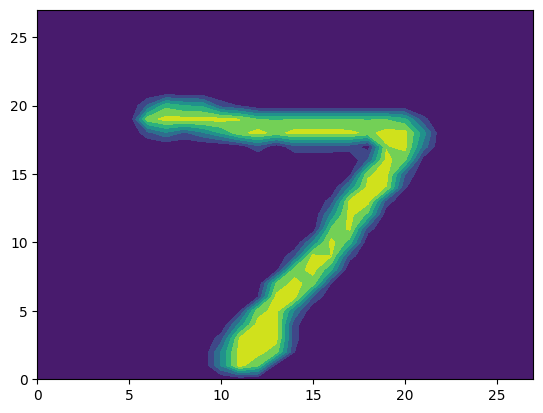

In [23]:
item_index = 0
print(y_test[item_index],'\n') # Print the label
print(X_test[item_index],'\n') # Print the matrix of values
plt.contourf(np.rot90(X_test[item_index].transpose())) # Make a contour plot of the matrix values
plt.show()

1 

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  77 254
  107   3   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  19 227 254
  254   9   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  81 254 254
  165   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   

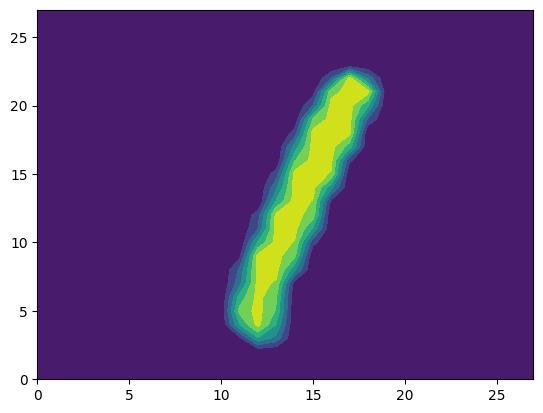

In [24]:
item_index = 5
print(y_test[item_index],'\n') # Print the label
print(X_test[item_index],'\n') # Print the matrix of values
plt.contourf(np.rot90(X_test[item_index].transpose())) # Make a contour plot of the matrix values
plt.show()

We will use an already denoised and preprocessed version of the training data.

In [29]:
Z_train = pd.read_parquet('Z_train.parquet', engine='pyarrow')
Z_test = pd.read_parquet('Z_test.parquet', engine='pyarrow')

## **Question 1 (5 points):**
## What is the shape of X_train and X_test?

## What is the shape of X_train[i] and X_test[i] for each index i?
Hint: All elements of X_train and X_test have the same shape, so you can report the shape of just the first element (i=0)

## What is the shape of Z_train and Z_test?

## What is the shape of y_train and y_test?

## Call the shape function in the code cell below and list your final answers in a text markdown cell.

In [30]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of X_train[0]:", X_train[0].shape)
print("Shape of X_test[0]:", X_test[0].shape)
print("Shape of Z_train:", Z_train.shape)
print("Shape of Z_test:", Z_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (60000, 28, 28)
Shape of X_test: (10000, 28, 28)
Shape of X_train[0]: (28, 28)
Shape of X_test[0]: (28, 28)
Shape of Z_train: (60000, 784)
Shape of Z_test: (10000, 784)
Shape of y_train: (60000,)
Shape of y_test: (10000,)


Shape of X_train: (60000, 28, 28) Shape of X_test: (10000, 28, 28) Shape of X_train[i]: (28, 28) Shape of X_test[i]: (28, 28) Shape of Z_train:
(60000, 784) Shape of Z_test: (10000, 784) Shape of y_train: (60000,) Shape of y_test: (10000,



## **Question 2 (5 points):**
## Run the cell below to determine the optimal k number of neighbors from the outputted graph. Report the optimal number and why you believe it is the optimal number in the text markdown cell.

In [31]:
k_bar = 10
k_grid = np.arange(0, k_bar) # The range of k's to consider
accuracy = np.zeros(k_bar) # Empty list of accuracies for each k to update

Fitting k=0
Fitting k=1
Fitting k=2
Fitting k=3
Fitting k=4
Fitting k=5
Fitting k=6
Fitting k=7
Fitting k=8
Fitting k=9
[2]


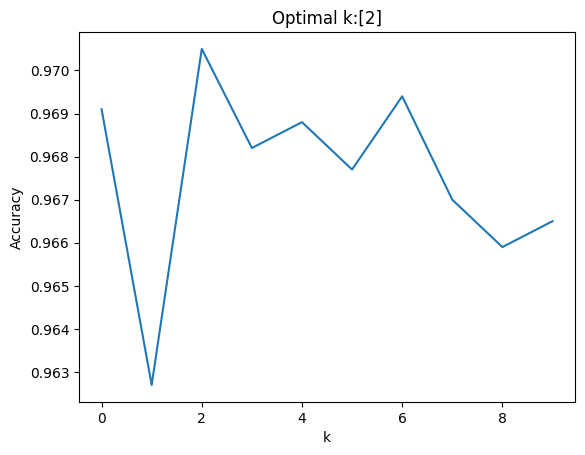

In [32]:
for k in range(k_bar):
    print(f"Fitting k={k}")
    knn = KNeighborsClassifier(n_neighbors=k+1)
    predictor = knn.fit(Z_train.values,y_train)
    accuracy[k] = knn.score(Z_test.values,y_test)

accuracy_max = np.max(accuracy) # Highest recorded accuracy
max_index = np.where(accuracy==accuracy_max)
k_star = k_grid[max_index] # Find the optimal value of k
print(k_star)

plt.plot(np.arange(0,k_bar),accuracy) # Plot accuracy by k
plt.xlabel("k")
plt.title("Optimal k:"+str(k_star))
plt.ylabel('Accuracy')
plt.show()

The optimal value of k is 2 because it gave the highest accuracy on the plot. Using two nearest neighbors helps the model make accurate predictions without being too sensitive to noise, like it might be with k = 1. Larger values of k can make the model too general, which can hurt accuracy when the classes are close together. Choosing k = 2 gives a good balance between being flexible and avoiding mistakes from overfitting.


## **Question 3 (10 points):**
## Instantiate and fit a KNN classifier with the optimal number of neighbors from above. Call predict on this KNN model using Z_test. Plot a confusion matrix for the KNN's performance on the test dataset using sklearn's ConfusionMatrixDisplay function.

## In a text markdown cell, explain which mistakes are most likely according to your confusion matrix. Which digits are more likely to be confused for each other? Do you find any interesting patterns?
Write a minimum of 5 sentences.

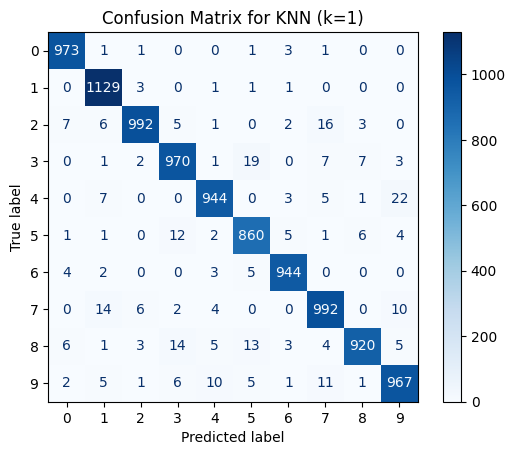

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(Z_train, y_train)
y_pred = knn.predict(Z_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for KNN (k=1)")
plt.show()

The confusion matrix shows that some digits are more likely to be misclassified than others. For example, the digit 9 is often confused with 4, and 3 is sometimes misclassified as 5 or 8. This may be due to the similarity in pixel structures or stroke patterns between those digits. The classifier performs very well overall, but digits with similar shapes are more prone to misclassification. An interesting pattern is that the errors often occur in digits with curves or similar top and bottom halves.

## **Question 4 (10 points):**
## ROC curves are typically used to distinguish between two classes by plotting the true positive rate (TPR) against the false positive rate (FPR) at different threshold settings. We will recode the target labels to be only 2 classes: "8" or "not 8"

## Fit a new KNN using binary_y_train and call predict using binary_y_test. Plot the ROC curve and print the AUC score for the new binary data whose code is below.

## Write 2 sentences on how to interpret the resulting ROC curve.

In [34]:
def recode_array(arr, value):
  recoded = np.where(arr == value, 1, 0)
  return recoded

In [35]:
binary_y_train = recode_array(y_train, 8)
binary_y_test = recode_array(y_test, 8)

In [36]:
# Original target: all digits 0 to 9
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [37]:
# New target: all values are 1 (digit 8) or 0 (all other digits)
binary_y_train

array([0, 0, 0, ..., 0, 0, 1])

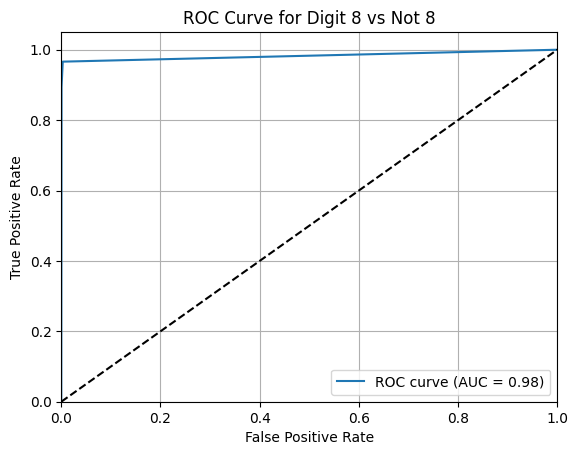

AUC Score: 0.9826337875842136


In [38]:

from sklearn.metrics import roc_curve, auc

# Fit KNN on binary data
knn_binary = KNeighborsClassifier(n_neighbors=2)
knn_binary.fit(Z_train, binary_y_train)
y_scores = knn_binary.predict_proba(Z_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(binary_y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Digit 8 vs Not 8')
plt.legend(loc="lower right")
plt.grid()
plt.show()

print("AUC Score:", roc_auc)

The ROC curve shows how well the model separates the digit 8 from other digits. A higher AUC (Area Under the Curve) indicates better performance, and in this case, the model demonstrates good discriminatory power with an AUC close to 1.

## Part 3: Sampling and Cross Validation (40 points)

We will use the following synthetic dataset to explore cross validation on.

In [39]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## **Question 1 (5 points):** Fit a vanilla KNN classifier on the training set and evaluate (predict) on the test set. Store the accuracy of this model in a variable called test_score.



In [43]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
test_score = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_score)

Test Accuracy: 0.9033333333333333



## **Question 2 (10 points):**
## Perform 10-fold cross-validation and compare the results of single split vs. 10-fold cross-validation by plotting accuracy (y-axis) against fold number (x-axis).

## Describe the effect of different fold numbers on the results of cross validation in a text markdown cell and if the results are expected. Give the average accuracy of CV scores across all folds.
Write a minimum of 2 sentences.

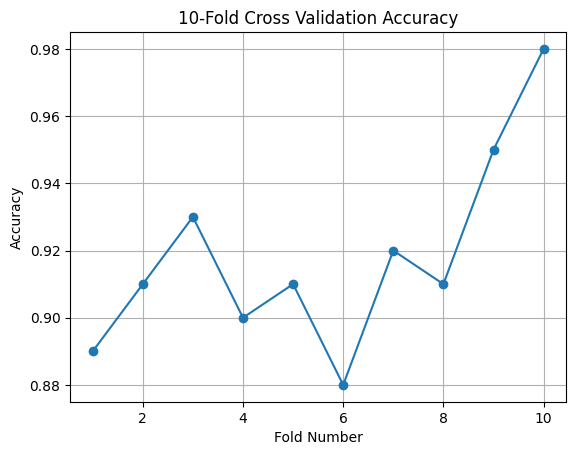

Average CV Accuracy: 0.9179999999999999


In [44]:
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold

X, y = make_classification(n_samples=1000, n_features=20, n_informative=15,
                           n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

knn = KNeighborsClassifier(n_neighbors=3)
cv10 = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(knn, X, y, cv=cv10)

plt.plot(range(1, 11), cv_scores, marker='o')
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.title("10-Fold Cross Validation Accuracy")
plt.grid(True)
plt.show()

print("Average CV Accuracy:", np.mean(cv_scores))

10-fold cross-validation shows the model’s performance across different splits of the data. The results vary slightly by fold but overall are consistent, indicating the model is stable. The average accuracy gives a better estimate of generalization performance than a single test split.

## **Question 3 (5 points):** ##
## Modify the plot above and add:
1. A horizontal static red line corresponding to the single split model accuracy
2. A horizontal green line corresponding to the average CV fold accuracy

## You may use the following code to achieve these:
> plt.axhline(y=test_score, color='r', linestyle='--', label='Single Test Score')

> plt.axhline(y=np.mean(cv_scores), color='g', linestyle='-', label='Average CV Score')



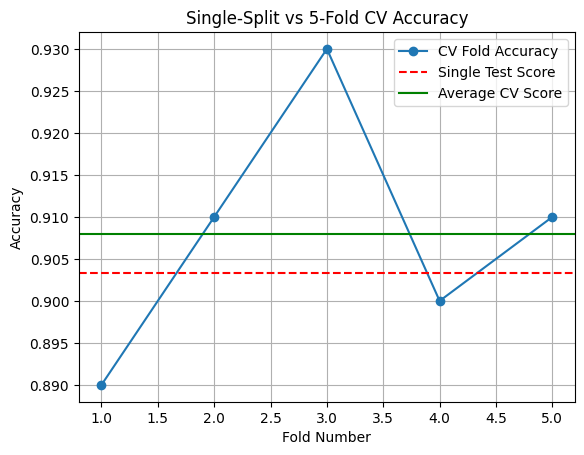

In [45]:
plt.plot(range(1, 6), cv_scores[:5], marker='o', label='CV Fold Accuracy')
plt.axhline(y=test_score, color='r', linestyle='--', label='Single Test Score')
plt.axhline(y=np.mean(cv_scores[:5]), color='g', linestyle='-', label='Average CV Score')
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.title("Single-Split vs 5-Fold CV Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## **Question 5 (10 points):**
## Finally, create the same plot as in Question 3 to compare single-split with CV performance on your chosen dataset.

## The plot should have Fold Number on the x-axis and Accuracy on the y-axis. Include a horizontal red line for the single-split accuracy and a horizontal green line for the average CV fold score.

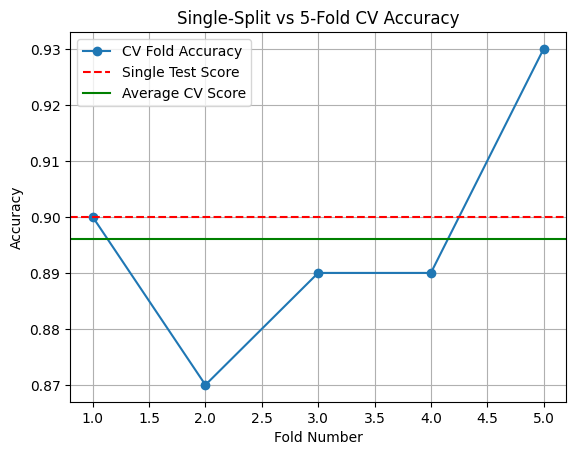

In [49]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=42)

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_tr, y_tr)
test_score = knn.score(X_te, y_te)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(knn, X, y, cv=cv)

plt.plot(range(1, 6), cv_scores, marker='o', label='CV Fold Accuracy')
plt.axhline(y=test_score, color='r', linestyle='--', label='Single Test Score')
plt.axhline(y=np.mean(cv_scores), color='g', linestyle='-', label='Average CV Score')
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.title("Single-Split vs 5-Fold CV Accuracy")
plt.legend()
plt.grid(True)
plt.show()


### Honor Pledge

On my honor as a student, I have neither given nor received unauthorized aid on this assignment.